In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
raw_data = joblib.load("data.pkl")
y = np.array(raw_data["labels"])
probs = {k: v[:, 1] for k, v in raw_data.items() if k != "labels"}

In [3]:
def plot_probs_vs_data_hist(p, y, n_bins = 10, color="grey", ecolor="red", err_bar_proba=0.96):
    err_bar_coef = st.norm().ppf(1 - (1 - err_bar_proba)/2)

    bins = np.quantile(p, np.linspace(0, 1, n_bins + 1))
    bins[0] = 0
    bins[-1] = 1

    bin_indicators = pd.cut(p, bins=bins, labels=False)

    expectations = np.zeros(n_bins)
    deviations = np.zeros(n_bins)
    observations = np.zeros(n_bins)

    for b in range(n_bins):
        mask = bin_indicators == b
        pm = p[mask]
        n = len(pm)

        expectations[b] = pm.mean()
        deviations[b] = np.sqrt((pm * (1 - pm)).sum() / n**2)
        observations[b] = y[mask].mean()

    expectations

    deviations

    # the bars of the plot will represent observations
    bar_width = 1
    plt.bar(x=np.arange(n_bins), height=observations, width=bar_width, color=color, edgecolor="none")

    # From the model we keep visible only the error bars
    plt.bar(x=np.arange(n_bins), height=expectations, width=bar_width, yerr=deviations * err_bar_coef, color="none",
           ecolor=ecolor)

    plt.xticks(ticks=np.arange(-0.5, n_bins + 0.5), 
               labels=[f"{x:.03f}" for x in bins],
               rotation='vertical');

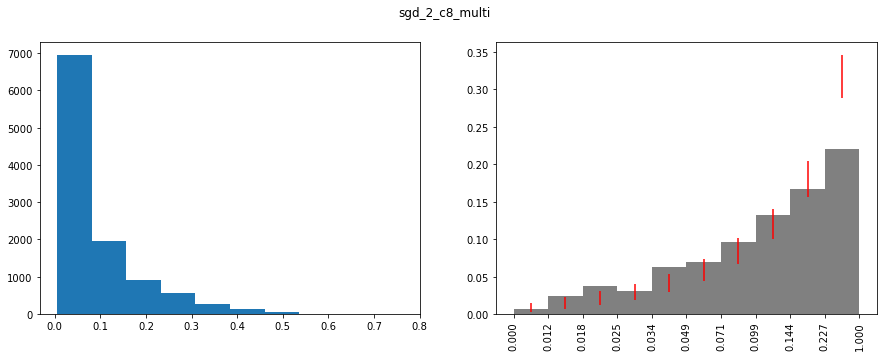

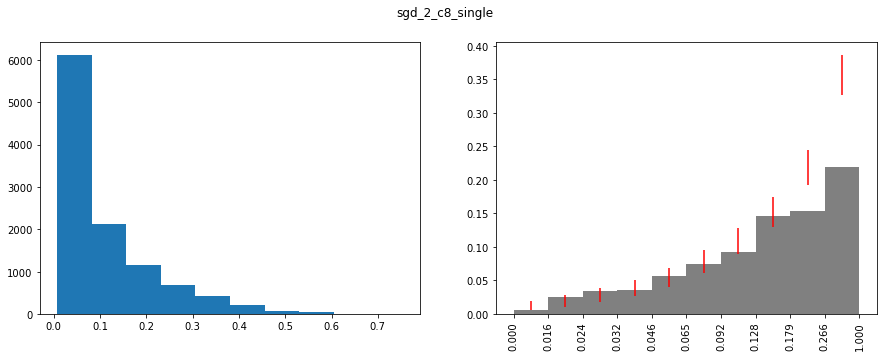

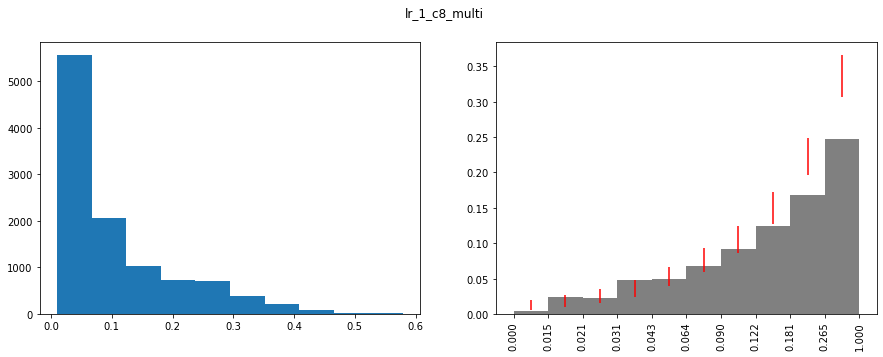

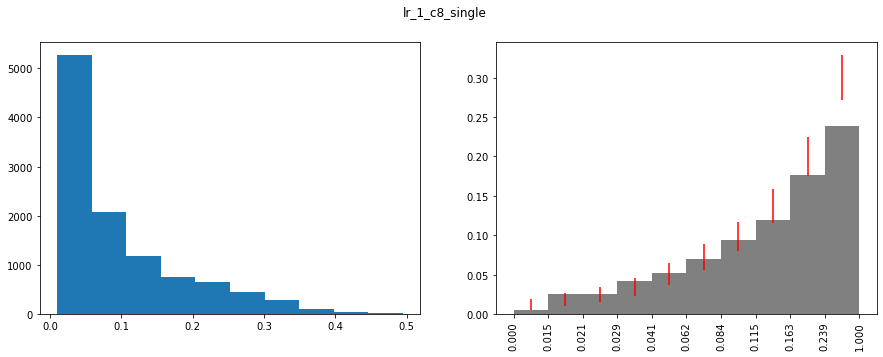

In [4]:
for model_name, model_probs in probs.items():
    fig, axs = plt.subplots(1, 2, figsize=[15, 5])
    
    ax = axs[0]
    ax.hist(model_probs)
    
    plt.sca(axs[1])
    plot_probs_vs_data_hist(p=model_probs, y=y, n_bins=10)
    
    fig.suptitle(model_name)

In [5]:
mask = model_probs > 0.24
p = model_probs[mask]
x = y[mask]

In [6]:
p.mean()

0.3012786324845496

In [7]:
x.mean()

0.24222431668237512

In [8]:
p

array([0.26115296, 0.26115296, 0.31801724, ..., 0.3727061 , 0.35174626,
       0.3727061 ])

In [9]:
len(p)

1061

(array([308., 242., 194., 133.,  68.,  48.,  34.,   8.,  14.,  12.]),
 array([0.24016173, 0.26563368, 0.29110562, 0.31657757, 0.34204951,
        0.36752146, 0.39299341, 0.41846535, 0.4439373 , 0.46940924,
        0.49488119]),
 <a list of 10 Patch objects>)

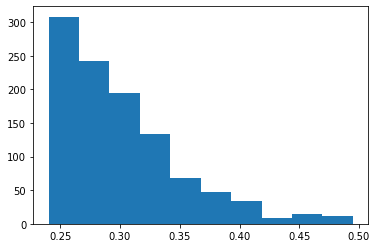

In [10]:
plt.hist(p)

# Exact density of sum of Bernoullis

In [11]:
mask = model_probs > 0.24
p = model_probs[mask]
x = y[mask]

In [12]:
def _conv_with_prob(f: np.ndarray, p: float) -> np.ndarray:
    """ Return convolution of `f` with `[1-p, p]`.
    
    Args:
        f: vector
        p: scalar
        
    Returns:
        vector of length `len(f) + 1`
    """
    return np.pad(f, [0, 1]) * (1-p) + np.pad(f, [1, 0]) * p

In [13]:
def get_density_of_sum_of_bernoullis(probs):
    f = np.array([1.])
    for p in probs:
        f = np.pad(f, [0, 1]) * (1-p) + np.pad(f, [1, 0]) * p
    return f
    

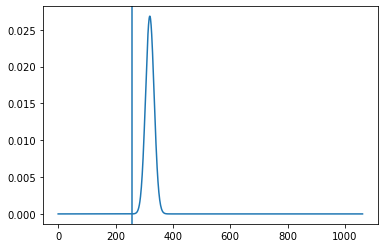

In [14]:
plt.plot(get_density_of_sum_of_bernoullis(p))
plt.axvline(x.sum())

# Models comparison

In [15]:
probs_df = pd.DataFrame(probs)
probs_df.head()

,sgd_2_c8_multi,sgd_2_c8_single,lr_1_c8_multi,lr_1_c8_single
0,0.259395,0.372094,0.290891,0.261153
1,0.293216,0.364808,0.290488,0.261153
2,0.147096,0.222262,0.156376,0.144403
3,0.019706,0.021429,0.021242,0.020793
4,0.052903,0.043556,0.068496,0.048818


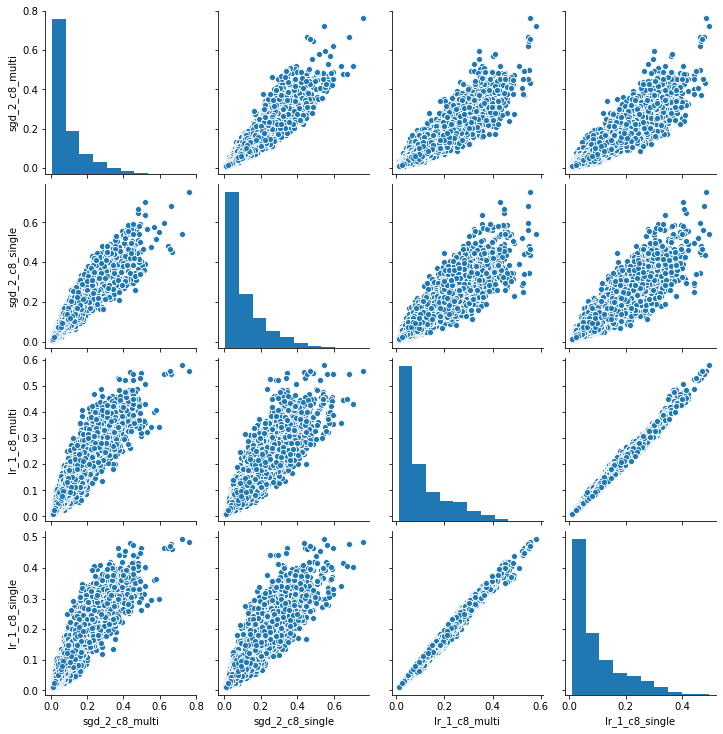

In [16]:
sns.pairplot(probs_df)

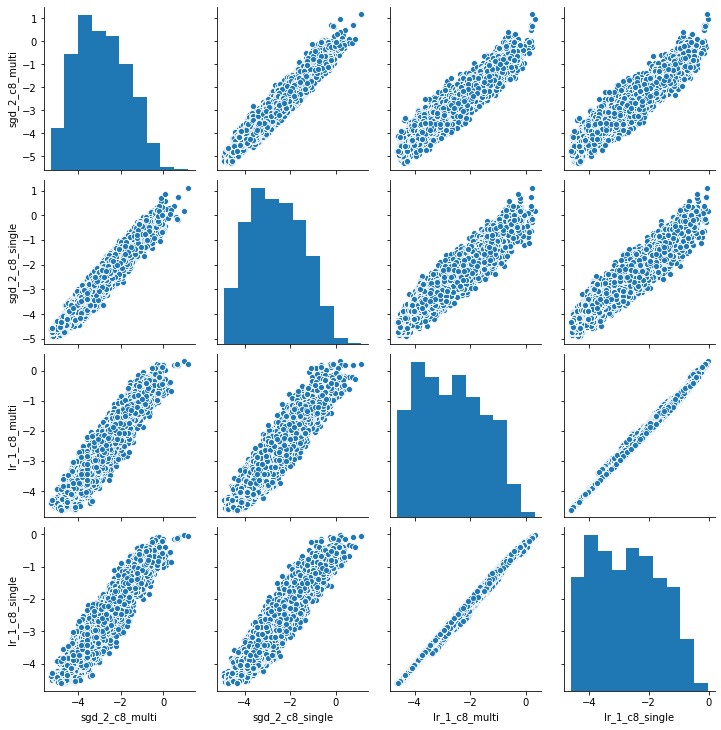

In [17]:
def log_odds(p):
    return np.log(p / (1-p))

sns.pairplot(log_odds(probs_df))